In [1]:
# hidden
import environment as env
env.initialize()

### Transformacion de los estados de las variables oceanograficas al emplazamiento

Este ejemplo continuará a partir de los datos temporales guardados al final del apartado [Pretratamiento de las series temporales de los agentes climáticos marítimos y atmosféricos](cl_lecturaypretratamiento_02.ipynb) para la variable altura de ola significante. Realizando el mismo procedimiento se obtienen las series temporales del periodo pico del oleaje y la dirección media de procedencia.

Se presenta un ejemplo de la metodología general de transformación oceanográfica de estados de oleaje offshore del punto 1052046 de la Red SIMAR de Puertos del Estado ubicado en la costa de Cádiz.

Las funciones que se utilizan son:

- mda_rbf.normalizar.normalizar
- mda_rbf.mda.mda
- mda_rbf.mda.plot_data_casos

- entrada_datos.lectura.lectura_propagacion_oleaje
- mda_rbf.reconstruction_rbf.plot_minim_c
- mda_rbf.reconstruction_rbf.reconstruction_agente
- mda_rbf.mda.plot_series_reconstruidas


In [2]:
# imports Anaconda
from __future__ import division
import matplotlib.dates as dates
import pandas as pd
import numpy as np
import os

# imports ROM 1.1
from entrada_datos import lectura
from mda_rbf import normalizar, mda, reconstruction_rbf
from clima_maritimo.clima_maritimo import pretratamiento_clima

dir_data = os.path.join(env.data_path, 'clima')

cadiz_hs_sim = pd.read_pickle(os.path.join(dir_data, 'cadiz_hs_sim.pkl')) 
cadiz_tp_sim = pd.read_pickle(os.path.join(dir_data, 'cadiz_tp_sim.pkl'))
cadiz_dh_sim = pd.read_pickle(os.path.join(dir_data, 'cadiz_dh_sim.pkl'))
cadiz_vv_sim = pd.read_pickle(os.path.join(dir_data, 'cadiz_vv_sim.pkl'))
cadiz_dv_sim = pd.read_pickle(os.path.join(dir_data, 'cadiz_dv_sim.pkl'))

NOTA: Se han leido los archivos originales (sin pretratamiento) dado que la propagación de los casos con modelo numérico se realizó con estas series.

La muestra original se divide en dos poblaciones: por un lado se considera la cola superior a partir del correspondiente umbral de altura de ola significante y, por otro, la cola inferior junto con el cuerpo central de la muestra. Se seleccionan los $m$ casos representativos de la variabilidad del conjunto.

En este caso se define el umbral como el percentil 90 y $m=500$.

In [3]:
c_i = 0.0001
c_f = 0.3
n_c = 100

U2 = cadiz_hs_sim.quantile(q=0.90).values[0]
ncasos_tot = 500

cadiz_sim = cadiz_hs_sim.join([cadiz_tp_sim, cadiz_dh_sim, cadiz_vv_sim, cadiz_dv_sim])
cadiz_sim.dropna(inplace=True)

n_sim = np.array(cadiz_sim.index.map(dates.date2num), dtype=np.float64)

##### Selección de casos representativos:

Para el caso del cuerpo central y cola inferior, se asigna una proporción de $2/3$ en relación a la cantidad de datos disponibles y el resto para la cola superior.

In [4]:
cadiz_cen = cadiz_sim.loc[cadiz_sim['hs'] <= U2]
ncasos_cen = int(np.floor(2 / 3 * ncasos_tot * (len(cadiz_cen) / len(cadiz_sim))))

En primer lugar se normalizan las variables de manera que la distancia entre dos puntos de la serie quede definida en el intervalo [0,1]. Esto se realiza mediante el uso de la función $normalizar$ en la que se indica la naturaleza de la vairable (0 variable escalar, 1 variable circular).

In [5]:
n_cen = np.array(cadiz_cen.index.map(dates.date2num), dtype=np.float64)
hs_cen_norm = normalizar.normalizar(cadiz_cen.hs.values, 0)
tp_cen_norm = normalizar.normalizar(cadiz_cen.tp.values, 0)
dh_cen_norm = normalizar.normalizar(cadiz_cen.dh.values, 1)
vv_cen_norm = normalizar.normalizar(cadiz_cen.vv.values, 0)
dv_cen_norm = normalizar.normalizar(cadiz_cen.dv.values, 1)
x_cen = np.vstack((hs_cen_norm, tp_cen_norm, dh_cen_norm, vv_cen_norm, dv_cen_norm)).T  

La selección de los casos representativos se realiza mediante la función $mda$. Para el uso de esta función se deben especificar los siguientes parámetros:

- esc: Columnas de la matriz de datos correspondientes a variables escalares.
- circ: Columnas de la matriz de datos correspondientes a variables circulares.
- id_: Identificador de la variable que determina el primer punto del subconjunto.

In [6]:
esc = np.array([0, 1, 3])
circ = np.array([2, 4])
id_ = 0
casos_cen = mda.mda(x_cen, esc, circ, ncasos_cen, id_)

n_casos_cen = n_cen[casos_cen]
var_casos_cen = x_cen[casos_cen, :]

mask_n_cen = np.searchsorted(n_sim, n_casos_cen)
cadiz_cen_casos = cadiz_sim.iloc[mask_n_cen, :]

En el caso de la cola superior se realiza el mismo procedimiento: 

In [7]:
cadiz_sup = cadiz_sim.loc[cadiz_sim['hs'] > U2]
ncasos_sup = ncasos_tot - ncasos_cen

n_sup = np.array(cadiz_sup.index.map(dates.date2num), dtype=np.float64)
hs_sup_norm = normalizar.normalizar(cadiz_sup.hs.values, 0)
tp_sup_norm = normalizar.normalizar(cadiz_sup.tp.values, 0)
dh_sup_norm = normalizar.normalizar(cadiz_sup.dh.values, 1)
vv_sup_norm = normalizar.normalizar(cadiz_sup.vv.values, 0)
dv_sup_norm = normalizar.normalizar(cadiz_sup.dv.values, 1)

x_sup = np.vstack((hs_sup_norm, tp_sup_norm, dh_sup_norm, vv_sup_norm, dv_sup_norm)).T  # variables normalizadas
casos_sup = mda.mda(x_sup, esc, circ, ncasos_sup, id_)

n_casos_sup = n_sup[casos_sup]
var_casos_sup = x_sup[casos_sup, :]

mask_n_sup = np.searchsorted(n_sim, n_casos_sup)
cadiz_sup_casos = cadiz_sim.iloc[mask_n_sup, :]

La función $plot\_data\_casos$ permite la visualización de los casos seleccionados

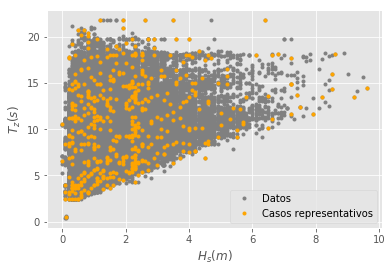

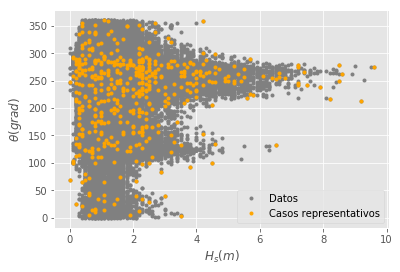

In [8]:
cadiz_sim_casos = pd.concat([cadiz_cen_casos, cadiz_sup_casos]).sort_index()
mda.plot_data_casos(cadiz_sim.hs.values, cadiz_sim.tp.values, cadiz_sim_casos.hs.values, cadiz_sim_casos.tp.values, '$H_s (m)$', '$T_z (s)$')
mda.plot_data_casos(cadiz_sim.hs.values, cadiz_sim.dh.values, cadiz_sim_casos.hs.values, cadiz_sim_casos.dh.values, '$H_s (m)$', r'$\theta (grad)$')

##### Lectura datos propagados:

El subconjunto seleccionado ha sido propagado mediante un modelo numérico. Dado que esto debe ser un paso separado, aqui solamente se cargan los resultados de la propagación.

In [9]:
# COLA INFERIOR Y CUERPO CENTRAL
cadiz_sim_prop_cen, cadiz_hs_sim_prop_cen, cadiz_tp_sim_prop_cen, cadiz_dh_sim_prop_cen = lectura.lectura_propagacion_oleaje(dir_data, 'cadiz_prop_infcen.txt')

# se eliminan los puntos con datos erroneos 
posincc = np.where((cadiz_sim_prop_cen == -999).any(1))[0]
var_casos_cen = np.delete(var_casos_cen, posincc, 0)
n_casos_cen = np.delete(n_casos_cen, posincc, 0)
cadiz_sim_prop_cen = cadiz_sim_prop_cen.loc[(cadiz_sim_prop_cen != -999).all(1)]

casos_cen_prop = cadiz_sim_prop_cen.values.T
serie_casos_prop_cen = np.vstack((n_casos_cen, casos_cen_prop)).T

# COLA SUPERIOR
[cadiz_sim_prop_sup, cadiz_hs_sim_prop_sup, cadiz_tp_sim_prop_sup, cadiz_dh_sim_prop_sup] = lectura.lectura_propagacion_oleaje(dir_data, 'cadiz_prop_sup.txt')

posincs = np.where((cadiz_sim_prop_sup == -999).any(1))[0]
var_casos_sup = np.delete(var_casos_sup, posincs, 0)
n_casos_sup = np.delete(n_casos_sup, posincs, 0)
cadiz_sim_prop_sup = cadiz_sim_prop_sup.loc[(cadiz_sim_prop_sup != -999).all(1)]

casos_sup_prop = cadiz_sim_prop_sup.values.T
serie_casos_prop_sup = np.vstack((n_casos_sup, casos_sup_prop)).T

#### Reconstrucción de serie en el emplazamiento

La función $reconstruction\_agente$ permite la reconstrucción de la serie temporal en el emplazamiento.  Se deben imponer los límites y el número de datos para la optimización del algoritmo de iterpolación ($c_i, c_f, n_c$).

NOTA: Dado que la función $reconstruction\_agente$ puede tardar un poco en ejecutar, se han guardado los resultados de la serie reconstruida a archivo y no se ejecutan en este ejemplo. 

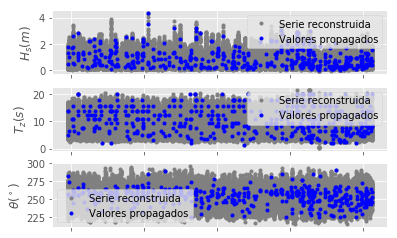

In [10]:
nvars = 3

c_i = 0.0001
c_f = 0.3
n_c = 100

# COLA INFERIOR Y CUERPO CENTRAL
# data_cen, vc_vars_cen, e_vars_cen, posmin_vars_cen = reconstruction_rbf.reconstruction_agente(x_cen, var_casos_cen, n_cen, casos_cen_prop, nvars, c_i, c_f, n_c, esc, circ)
data_cen = np.loadtxt(os.path.join(dir_data, 'serie_recons_cen'))

# COLA SUPERIOR
# data_sup, vc_vars_sup, e_vars_sup, posmin_vars_sup = reconstruction_rbf.reconstruction_agente(x_sup, var_casos_sup, n_sup, casos_sup_prop, nvars, c_i, c_f, n_c, esc, circ)
data_sup = np.loadtxt(os.path.join(dir_data, 'serie_recons_sup'))
        
serie_casos_prop = np.vstack((serie_casos_prop_cen, serie_casos_prop_sup))
serie_reconstruida = np.vstack((data_cen.T, data_sup.T))
mda.plot_series_reconstruidas(serie_reconstruida, serie_casos_prop, 3)

serie_reconstruida_ord = serie_reconstruida[serie_reconstruida[:,0].argsort()]
cadiz_hs_sim_emp = pd.DataFrame(serie_reconstruida_ord[:, 1], index=cadiz_sim.index, columns=['hs'])
cadiz_tp_sim_emp = pd.DataFrame(serie_reconstruida_ord[:, 2], index=cadiz_sim.index, columns=['tp'])
cadiz_dh_sim_emp = pd.DataFrame(serie_reconstruida_ord[:, 3], index=cadiz_sim.index, columns=['dh'])


NOTA: Se aplica la función $interp\_distrib$ presentada en el apartado [Pretratamiento de las series temporales de los agentes climáticos marítimos y atmosféricos](cl_lectura_pretratamiento_02.ipynb):

In [11]:
cadiz_hs_sim_emp = pretratamiento_clima.interp_distrib(0.8, cadiz_hs_sim_emp)
cadiz_tp_sim_emp = pretratamiento_clima.interp_distrib(0.8, cadiz_tp_sim_emp)
cadiz_dh_sim_emp = pretratamiento_clima.interp_distrib(0.8, cadiz_dh_sim_emp)

Se guardan los datos a archivo:

In [12]:
cadiz_hs_sim_emp.to_pickle(os.path.join(dir_data, 'cadiz_hs_sim_emp.pkl'))
cadiz_tp_sim_emp.to_pickle(os.path.join(dir_data, 'cadiz_tp_sim_emp.pkl'))
cadiz_dh_sim_emp.to_pickle(os.path.join(dir_data, 'cadiz_dh_sim_emp.pkl'))

Con las series temporales de las variables de interés en el emplazamiento, se puede proceder al cálculo del regimén extremal de la variable predominante que se presenta en el apartado [Distribución de extremos de la variable predominante](cl_regimenextremal_01.ipynb).